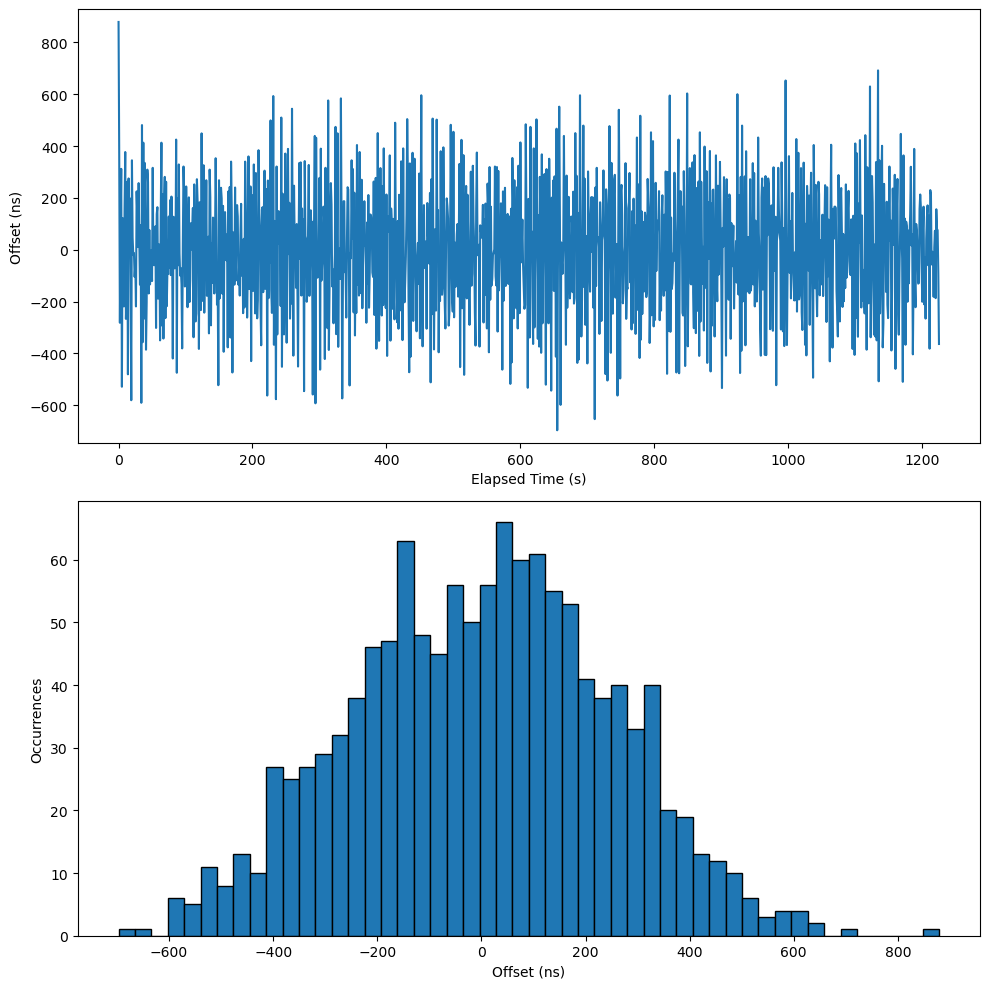

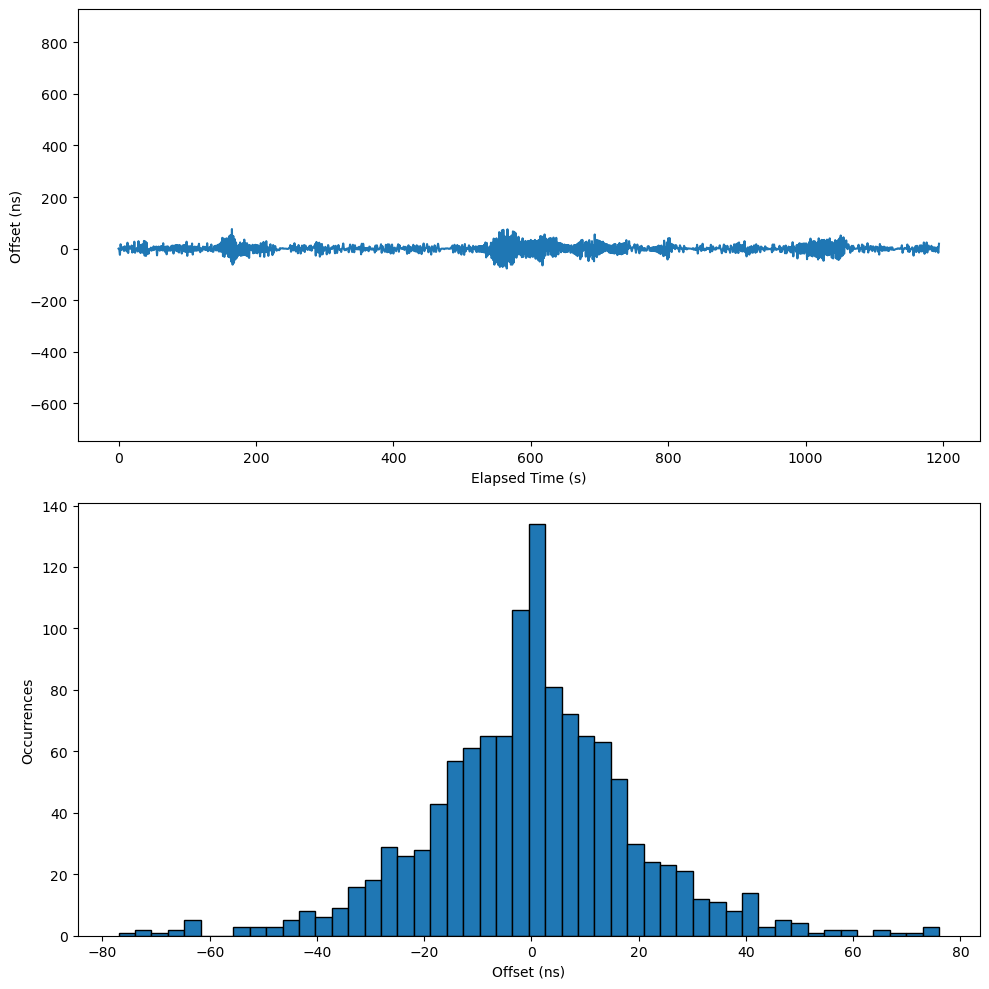

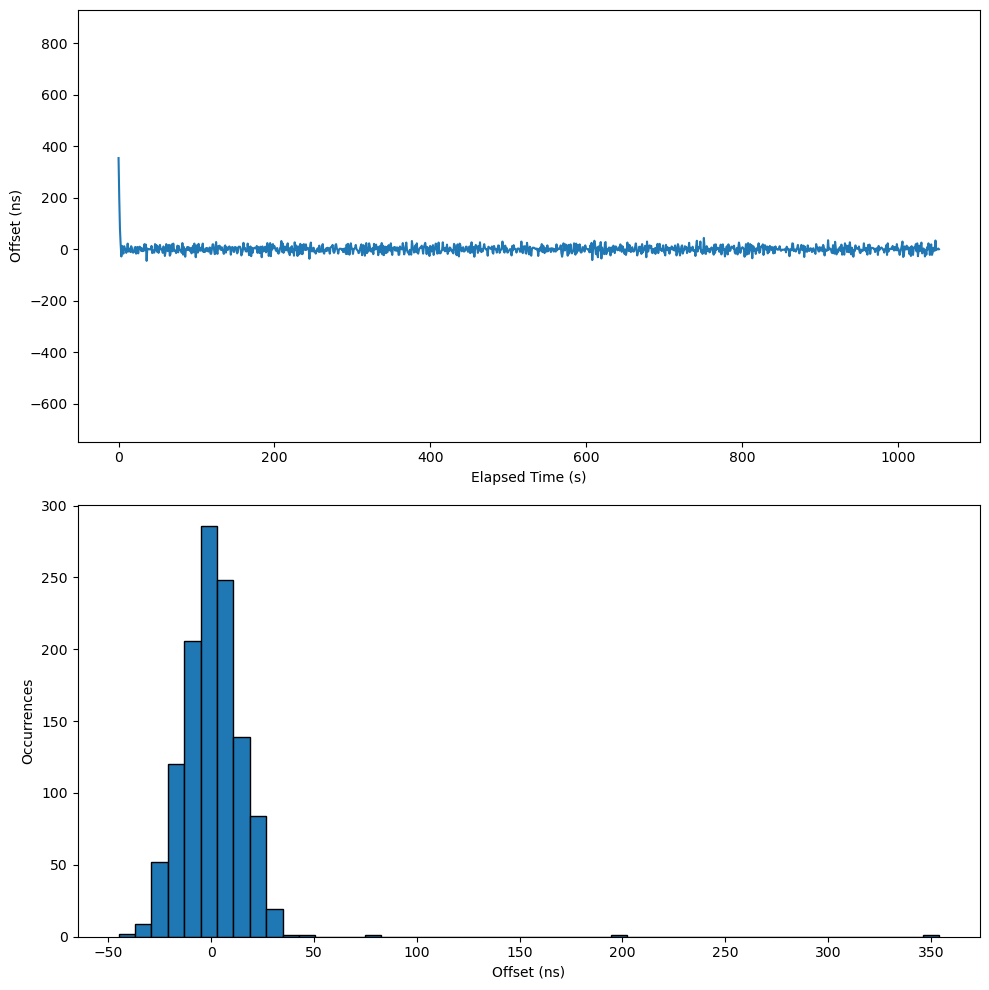

In [89]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

# Lista todos os arquivos .txt no diretório log_outputs
log_files = glob.glob('log_outputs/*.txt')

def process_log_file(log_file):
    """Processa um arquivo de log e retorna um DataFrame."""
    with open(log_file, 'r') as file:
        log_data = file.read()
    
    # Extrai os dados de offset usando expressão regular
    offset_data = re.findall(r'ptp4l\[(\d+\.\d+)\]: master offset\s+(-?\d+)', log_data)
    
    # Cria um DataFrame com as colunas apropriadas
    df = pd.DataFrame(offset_data, columns=['elapsed_time', 'offset'])
    
    # Converte as colunas para valores numéricos
    df['elapsed_time'] = pd.to_numeric(df['elapsed_time'])
    df['offset'] = pd.to_numeric(df['offset'])
    
    # Calcula a diferença de tempo entre amostras consecutivas e ajusta a coluna 'seconds'
    df['time_difference'] = df['elapsed_time'].diff()
    df['seconds'] = df['elapsed_time'] - df['elapsed_time'].iloc[0]
    
    return df

# Determina os limites globais para os offsets
global_min_offset = float('inf')
global_max_offset = float('-inf')

for log_file in log_files:
    df = process_log_file(log_file)
    min_offset = df['offset'].min()
    max_offset = df['offset'].max()
    if min_offset < global_min_offset:
        global_min_offset = min_offset
    if max_offset > global_max_offset:
        global_max_offset = max_offset

# Ajusta para ter um pouco de espaço extra
global_min_offset -= 50
global_max_offset += 50

for i, log_file in enumerate(log_files):
    df = process_log_file(log_file)
    
    # Cria uma figura com subplots um abaixo do outro para o arquivo de log atual
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    
    # Gráfico de linha para offset ao longo do tempo
    axs[0].plot(df['seconds'], df['offset'])
    axs[0].set(xlabel='Elapsed Time (s)', ylabel='Offset (ns)')
    axs[0].set_ylim([global_min_offset, global_max_offset])  # Aplica os limites globais apenas aqui
    
    # Histograma para os offsets
    axs[1].hist(df['offset'], bins=50, edgecolor='black')  # Remove a restrição de range
    axs[1].set(xlabel='Offset (ns)', ylabel='Occurrences')
    
    plt.tight_layout()
    
    # Gera um nome de arquivo baseado no nome do arquivo de log
    base_name = os.path.basename(log_file)
    plot_file_name = f'results_plots/{base_name}_results.png'
    
    plt.savefig(plot_file_name, format='png', bbox_inches='tight')
    plt.show()

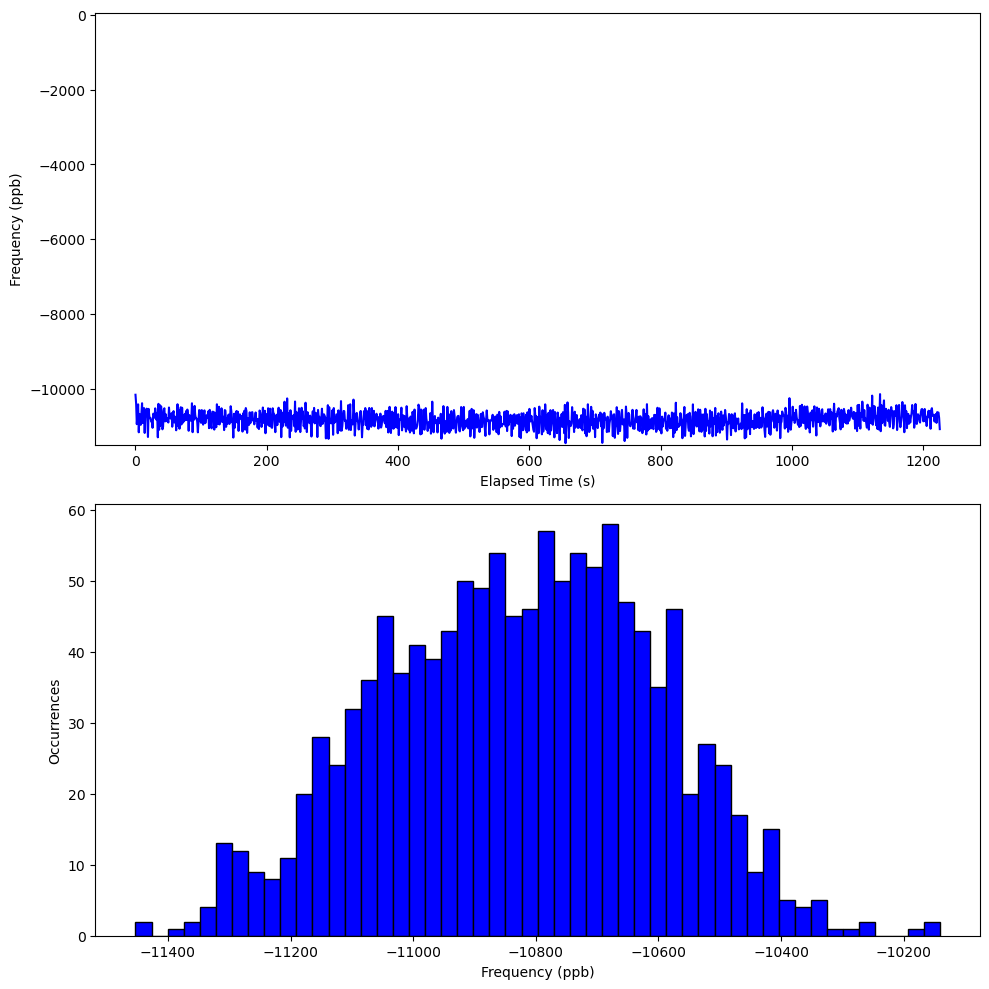

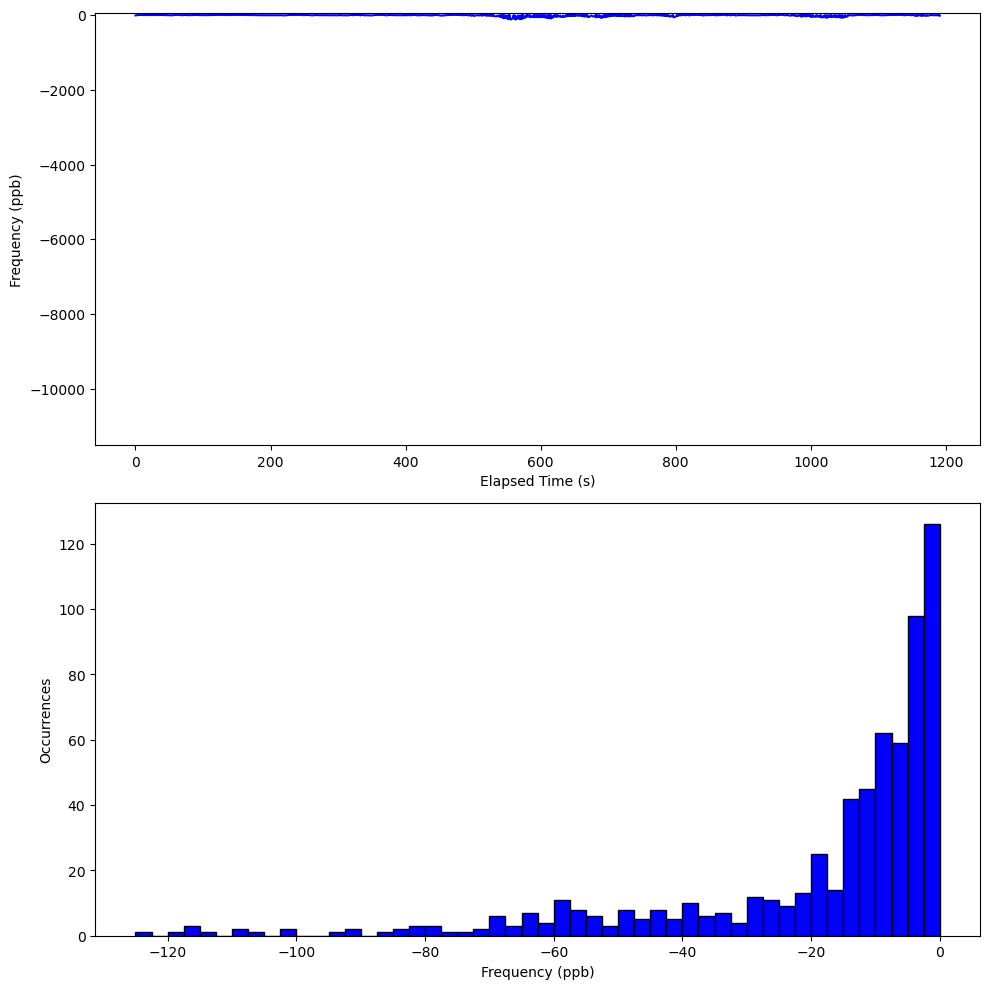

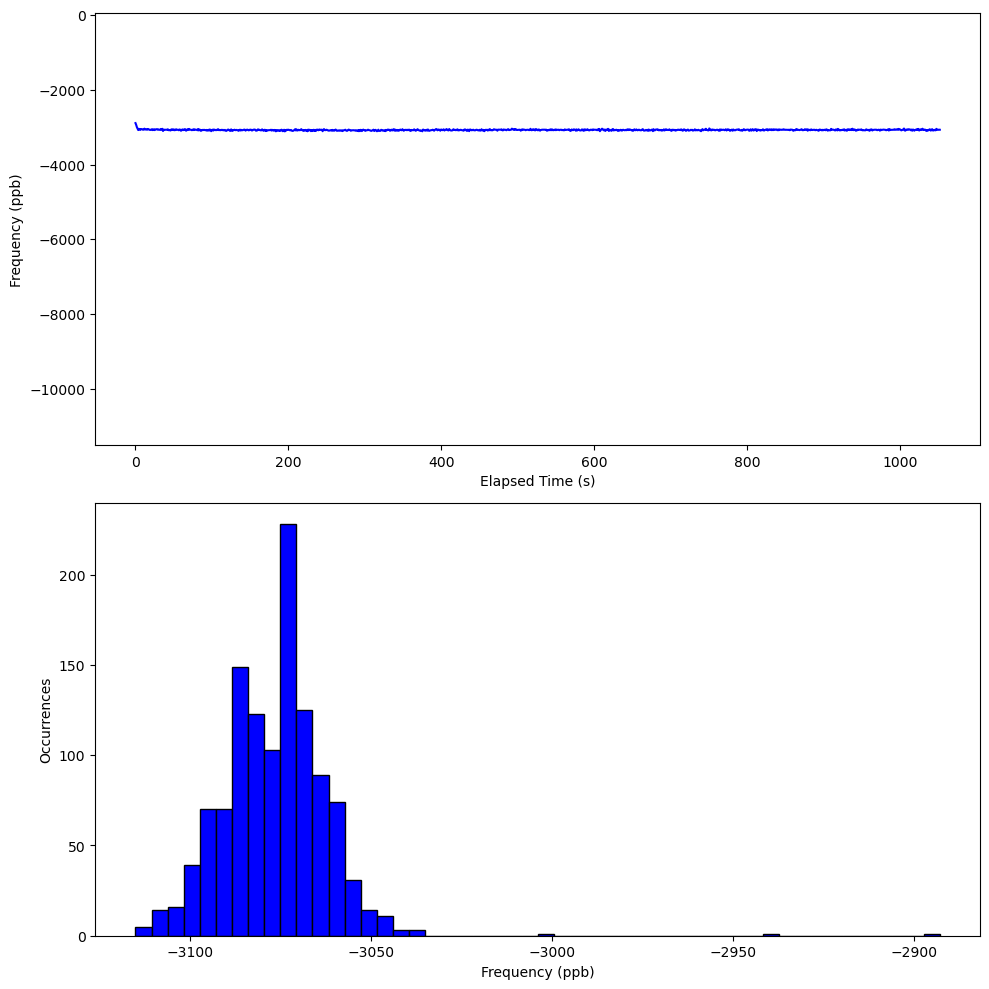

In [90]:
# Lista todos os arquivos .txt no diretório log_outputs
log_files = glob.glob('log_outputs/*.txt')

def process_log_file(log_file):
    """Processa um arquivo de log e retorna um DataFrame."""
    with open(log_file, 'r') as file:
        log_data = file.read()
    
    # Extrai os dados de frequência usando expressão regular
    freq_data = re.findall(r'ptp4l\[(\d+\.\d+)\]: master offset\s+-?\d+ s2 freq\s+(-?\d+)', log_data)
    
    # Cria um DataFrame com as colunas apropriadas
    df = pd.DataFrame(freq_data, columns=['elapsed_time', 'frequency'])
    
    # Converte as colunas para valores numéricos
    df['elapsed_time'] = pd.to_numeric(df['elapsed_time'])
    df['frequency'] = pd.to_numeric(df['frequency'])
    
    # Calcula a diferença de tempo entre amostras consecutivas e ajusta a coluna 'seconds'
    df['time_difference'] = df['elapsed_time'].diff()
    df['seconds'] = df['elapsed_time'] - df['elapsed_time'].iloc[0]
    
    return df

# Determina os limites globais para as frequências
global_min_freq = float('inf')
global_max_freq = float('-inf')

for log_file in log_files:
    df = process_log_file(log_file)
    min_freq = df['frequency'].min()
    max_freq = df['frequency'].max()
    if min_freq < global_min_freq:
        global_min_freq = min_freq
    if max_freq > global_max_freq:
        global_max_freq = max_freq

# Ajusta para ter um pouco de espaço extra
global_min_freq -= 50
global_max_freq += 50

for i, log_file in enumerate(log_files):
    df = process_log_file(log_file)
    
    # Cria uma figura com subplots um abaixo do outro para o arquivo de log atual
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    
    # Gráfico de linha para frequência ao longo do tempo
    axs[0].plot(df['seconds'], df['frequency'], color='blue')
    axs[0].set(xlabel='Elapsed Time (s)', ylabel='Frequency (ppb)')
    axs[0].set_ylim([global_min_freq, global_max_freq])  # Aplica os limites globais apenas aqui
    
    # Histograma para as frequências
    axs[1].hist(df['frequency'], bins=50, edgecolor='black', color='blue')
    axs[1].set(xlabel='Frequency (ppb)', ylabel='Occurrences')
    
    plt.tight_layout()
    
    # Gera um nome de arquivo baseado no nome do arquivo de log
    base_name = os.path.basename(log_file)
    plot_file_name = f'results_plots/{base_name}_freq_results.png'
    
    plt.savefig(plot_file_name, format='png', bbox_inches='tight')
    plt.show()